In [1]:
#combine files 
import glob 
import os
#clean 
import string
import pandas as pd
import numpy as np
import emoji
import nltk
import re 
from cleantext import clean
#sleep timer 
import time 
import logging
import threading
#show most common words
from collections import Counter
#word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('JNE_batam.csv')
#only keep caption column 
df1 = df[['caption']]
df1 = df1.dropna()

In [3]:
df1['middle'] = df1['caption'].str.split(")").str[1] 
df1['reviews'] = df1['middle'].str.split("(").str[0]

df1 = df1.reset_index()

In [4]:
df1['reviews'].fillna('0', inplace = True)
for i, row in df1.iterrows(): 
    review = row['reviews']
    if review == '0':
        df1['reviews'][i] = review.replace('0', row['caption'])

/var/folders/5w/0kxl7gbj5vqb93sccvkxwrzc0000gn/T/ipykernel_42373/1854476216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews'][i] = review.replace('0', row['caption'])


In [5]:
df1 = df1.rename(columns={'reviews': 'JNE Reviews'})
df1

,index,caption,middle,JNE Reviews
0,0,24 hours for the incoming storage,NaN,24 hours for the incoming storage
1,4,"(Translated by Google) Delicious taste, servic...","Delicious taste, service a little slow (Orig...","Delicious taste, service a little slow"
2,7,(Translated by Google) jne is very bad... it's...,jne is very bad... it's been too late to ask ...,jne is very bad... it's been too late to ask ...
3,8,(Translated by Google) TAIIK SLOW EXPEDITION ...,TAIIK SLOW EXPEDITION (Original,TAIIK SLOW EXPEDITION
4,10,"(Translated by Google) The service is good, fr...","The service is good, friendly. The management...","The service is good, friendly. The management..."
...,...,...,...,...
557,919,(Translated by Google) Frequent interference ...,Frequent interference (Original,Frequent interference
558,923,(Translated by Google) PLEASE PACKAGE SY DR CU...,PLEASE PACKAGE SY DR CUSTOMER 30 GA SMPE2 STI...,PLEASE PACKAGE SY DR CUSTOMER 30 GA SMPE2 STI...
559,924,(Translated by Google) My advice is not to pro...,My advice is not to provide services if you c...,My advice is not to provide services if you c...
560,925,(Translated by Google) You say the overloads a...,You say the overloads are piled up in the war...,You say the overloads are piled up in the war...


In [6]:
df1['JNE Reviews'].to_csv('jne1.csv')

### Clean the data

In [7]:
df_combi = pd.read_csv('jne1.csv')

from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and lemmatize/stem.'''
    text = str(text).lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = clean(text, no_emoji=True)
    text = emoji.demojize(text, delimiters=("", "")) #change emoji into text 
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df_combi['clean_1'] = pd.DataFrame(df_combi['JNE Reviews'].apply(clean_text_round1))
df_combi

,Unnamed: 0,JNE Reviews,clean_1
0,0,24 hours for the incoming storage,hours incoming storage
1,1,"Delicious taste, service a little slow",delicious taste service little slow
2,2,jne is very bad... it's been too late to ask ...,jne bad late ask forgiveness goods delivered s...
3,3,TAIIK SLOW EXPEDITION,taiik slow expedition
4,4,"The service is good, friendly. The management...",service good friendly management taking money ...
...,...,...,...
557,557,Frequent interference,frequent interference
558,558,PLEASE PACKAGE SY DR CUSTOMER 30 GA SMPE2 STI...,please package sy dr customer ga still batam w...
559,559,My advice is not to provide services if you c...,advice provide services cant serve well ...
560,560,You say the overloads are piled up in the war...,say overloads piled warehouse airport come fel...


### Sentiment analysis 


In [8]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
def clean_text_round2(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output
df_combi['clean_2'] = pd.DataFrame(df_combi['clean_1'].apply(clean_text_round2))


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    if sentiment_dict['compound'] >= 0.05 : 
       return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
       return "Neutral"
        
df_combi['sentiment'] = pd.DataFrame(df_combi['JNE Reviews'].apply(sentiment_scores))

In [10]:
df_combi

,Unnamed: 0,JNE Reviews,clean_1,clean_2,sentiment
0,0,24 hours for the incoming storage,hours incoming storage,hour incoming storage,Neutral
1,1,"Delicious taste, service a little slow",delicious taste service little slow,delicious taste service little slow,Positive
2,2,jne is very bad... it's been too late to ask ...,jne bad late ask forgiveness goods delivered s...,jne bad late ask forgiveness good delivered sl...,Negative
3,3,TAIIK SLOW EXPEDITION,taiik slow expedition,taiik slow expedition,Neutral
4,4,"The service is good, friendly. The management...",service good friendly management taking money ...,service good friendly management taking money ...,Positive
...,...,...,...,...,...
557,557,Frequent interference,frequent interference,frequent interference,Neutral
558,558,PLEASE PACKAGE SY DR CUSTOMER 30 GA SMPE2 STI...,please package sy dr customer ga still batam w...,please package sy dr customer ga still batam w...,Negative
559,559,My advice is not to provide services if you c...,advice provide services cant serve well ...,advice provide service cant serve well ...,Negative
560,560,You say the overloads are piled up in the war...,say overloads piled warehouse airport come fel...,say overload piled warehouse airport come fell...,Neutral


In [11]:
df_neg = df_combi.drop(df_combi[df_combi['sentiment'] != 'Negative'].index)
df_neg = df_neg[['clean_2']]
df_neg

,clean_2
2,jne bad late ask forgiveness good delivered sl...
6,njir bad really slow point use jne ...
7,bit surprised little disappointed shipping bat...
8,worst jne bad service handle product bad good ...
10,worker professional clear package tracking sit...
...,...
553,bad service often deceive customer
556,bad disappointing solution reason shortage air...
558,please package sy dr customer ga still batam w...
559,advice provide service cant serve well ...


In [12]:
#combining the text into one long string for word cloud 
cloud_string = df_neg['clean_2'].str.cat(sep=' ')

In [27]:
# Let's first pull out the top 30 words for each category
words = []
for word in cloud_string.split():
        words.append(word)
Counter(words).most_common()

[('...', 62),
 ('call', 31),
 ('delivery', 26),
 ('bad', 21),
 ('item', 20),
 ('service', 17),
 ('staff', 17),
 ('day', 15),
 ('sent', 14),
 ('kerry', 12),
 ('customer', 11),
 ('send', 11),
 ('work', 10),
 ('time', 10),
 ('yet', 9),
 ('good', 9),
 ('terrible', 9),
 ('dont', 9),
 ('cant', 9),
 ('one', 9),
 ('arrived', 9),
 ('product', 9),
 ('received', 8),
 ('branch', 8),
 ('delivered', 8),
 ('answer', 8),
 ('check', 8),
 ('called', 8),
 ('still', 8),
 ('number', 8),
 ('havent', 7),
 ('phone', 7),
 ('person', 7),
 ('contact', 7),
 ('slow', 7),
 ('pick', 7),
 ('employee', 7),
 ('today', 7),
 ('well', 6),
 ('waiting', 6),
 ('stuff', 6),
 ('deliver', 6),
 ('ask', 6),
 ('company', 6),
 ('rotten', 5),
 ('like', 5),
 ('know', 5),
 ('even', 5),
 ('parcel', 5),
 ('tell', 5),
 ('box', 5),
 ('since', 5),
 ('address', 5),
 ('doesnt', 5),
 ('come', 5),
 ('center', 5),
 ('badly', 4),
 ('wait', 4),
 ('lot', 4),
 ('people', 4),
 ('many', 4),
 ('long', 4),
 ('say', 4),
 ('though', 4),
 ('calling', 4),


In [13]:
#add meaningless words to stopwords
add_stop_words = ['...' , 'call', 'dont', 'cant']
stop_words = add_stop_words + stop 

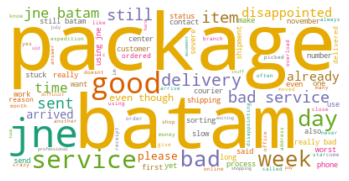

In [14]:
#wordcloud for top 100 words 
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, max_words = 100)

wordcloud = wc.generate(cloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

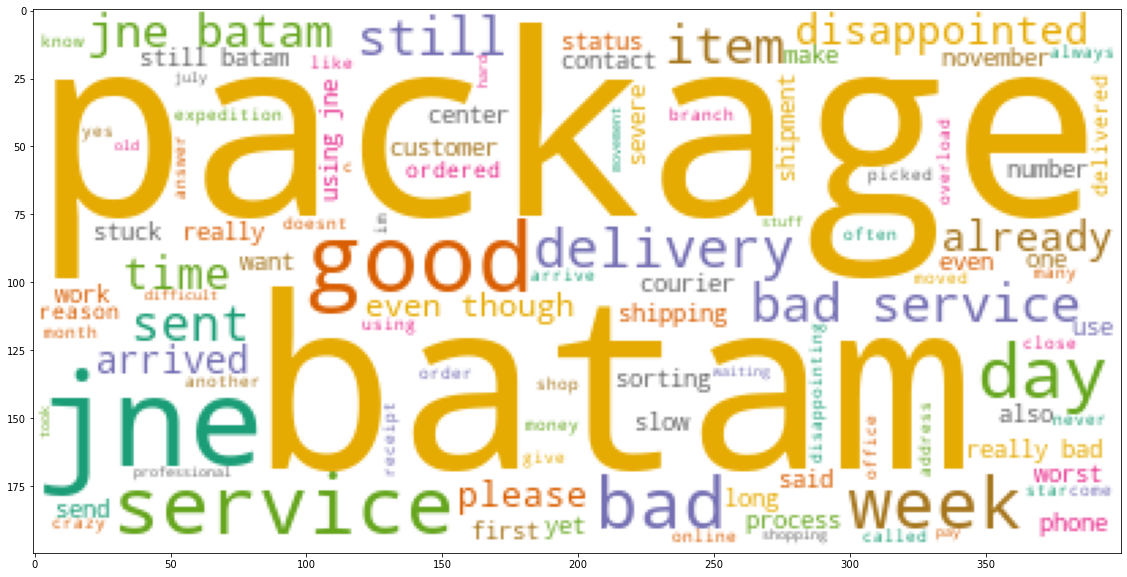

In [15]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)

In [16]:
late_words = ['slow', 'late', 'long']
df_late = df_neg[df_neg['clean_2'].str.contains('|'.join(late_words))]
df_late = df_late.rename(columns ={'clean_2':'Late reviews'})

In [17]:
df_late

,Late reviews
2,jne bad late ask forgiveness good delivered sl...
6,njir bad really slow point use jne ...
15,send document incidentally include taxable goo...
29,shipping holded long time offer make package f...
33,bad long day since package moving ...
36,shipping good difficult sending clothes must n...
85,ordered good august arrived batam dufah august...
116,bad service slow delivery
131,took long get loss customer took long customer...
148,delivery slow use regular jne batam pekanbaru ...


In [18]:
df_late.to_csv('Late_reviews_jne.csv')